In [1]:
import pvdeg.stressor
import matplotlib.pyplot as plt

In [2]:
points = pvdeg.stressor.chamber_setpoints(
    fp = r'C:\Users\tford\Downloads\Simple Setpoints.csv',
    t_0=0,
    rh_0=0,
    irrad_0=0,
    v_0=0,
    )

<Axes: >

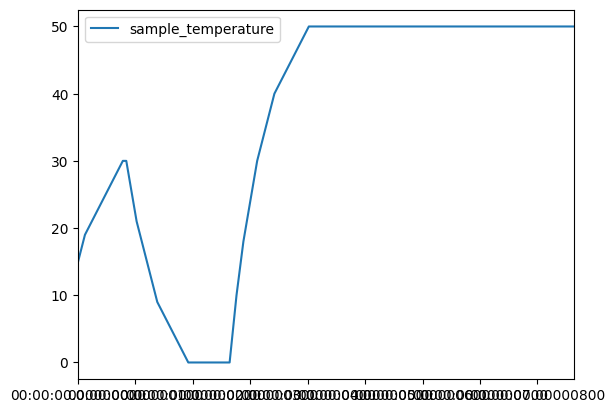

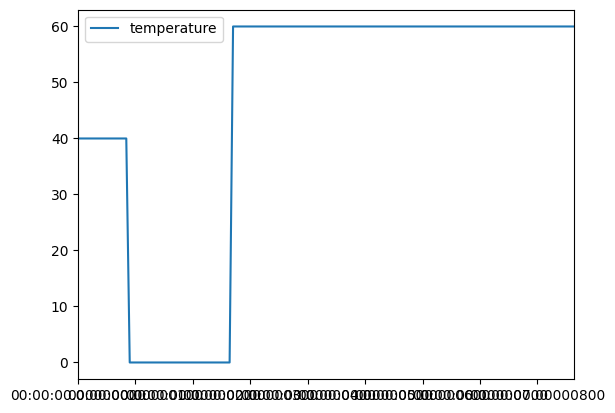

In [3]:
props = pvdeg.stressor.chamber_properties(points, tau=10, chamber_irrad_0=0, sample_temp_0=15)

props.plot(y='sample_temperature')
points.plot(y='temperature')

<Axes: >

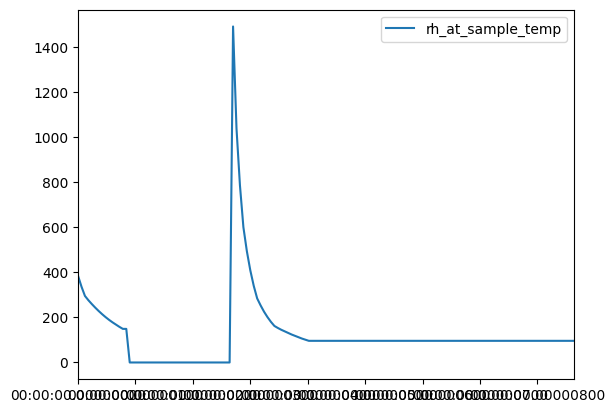

In [4]:
props.plot(y=3)

In [6]:
props

,water_vapor_pressure,dew_point,sample_temperature,rh_at_sample_temp
0 days 00:00:00,6.403438,37.126529,15,384
0 days 00:01:00,6.403438,37.126529,17,336
0 days 00:02:00,6.403438,37.126529,19,295
0 days 00:03:00,6.403438,37.126529,20,276
0 days 00:04:00,6.403438,37.126529,21,259
...,...,...,...,...
0 days 02:20:00,12.212517,49.660466,50,96
0 days 02:21:00,12.212517,49.660466,50,96
0 days 02:22:00,12.212517,49.660466,50,96
0 days 02:23:00,12.212517,49.660466,50,96


In [15]:
from numba import njit
import numpy as np
from typing import Union 

In [21]:
@njit
def equilibrium_eva_water(
    sample_temp: Union[float, np.ndarray],
    rh_at_sample_temp: Union[float, np.ndarray],
    eva_solubility: float,
    solubility_prefactor: float,
)-> Union[float, np.ndarray[float]]:
    """
    Calculate Equlibirum EVA H20 content [g/cm^3]

    Parameters:
    -----------
    sample_temp:
        temperature of the sample [C]
    rh_at_sample_temp:
        relative humidity at the sample temperature [%, unitless]
    eva_solubility:
        activation energy for solubility in EVA [eV] 
    solubility_prefactor:
        amount of substance already present [g/cm^3] 
        >>> should this just say water present at t=0
    """

    return (solubility_prefactor*np.exp(-eva_solubility/0.0000861733241/(273.15+sample_temp)))*rh_at_sample_temp/100

In [22]:
a = np.arange(0, 5)
b = np.arange(5, 10)

In [23]:
equilibrium_eva_water(
    sample_temp=a,
    rh_at_sample_temp=b,
    eva_solubility=0.173,
    solubility_prefactor=1.18
)

array([3.79227590e-05, 4.67438261e-05, 5.60053484e-05, 6.57197941e-05,
       7.58998041e-05])